In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('No GPU found')
else:
  print(gpu_info)

Mon Jun 10 11:17:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   54C    P5             19W /  140W |    1145MiB /   6144MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install pennylane pennylane-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.models as models
from torchvision.models import inception_v3, Inception_V3_Weights
import torch.nn.functional as F
from torch.autograd import grad
from torch.optim import Adam
import torch.autograd as autograd
import torch.nn.utils.spectral_norm as spectral_norm
from pytorch_fid import fid_score
from scipy.linalg import sqrtm
import torchvision
from torchsummary import summary
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import math
import numpy as np
import h5py
from h5py import File as HDF5File
from sklearn.decomposition import PCA
%matplotlib inline
import torch.nn as nn
from PIL import Image
import matplotlib.animation as animation
from IPython.display import HTML
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import pennylane as qml
import random

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Testing on MNIST dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f"Image batch dimensions: {images.shape}")
print(f"Label batch dimensions: {labels.shape}")

Image batch dimensions: torch.Size([64, 1, 28, 28])
Label batch dimensions: torch.Size([64])


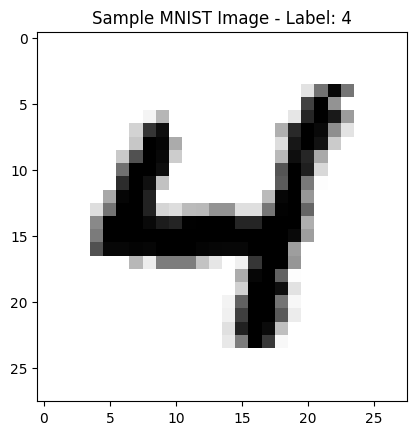

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.title(f"Sample MNIST Image - Label: {labels[0].item()}")
plt.show()

In [ ]:
n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

In [ ]:

def quantum_circuit(params, n_qubits=4):
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])
    for i in range(n_qubits):
        qml.RZ(params[n_qubits + i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)
qnode = qml.QNode(quantum_circuit, dev)


params = np.random.uniform(0, np.pi, 2 * n_qubits)
print("Quantum circuit output with random parameters:", qnode(params))

Quantum circuit output with random parameters: [tensor(0.01916946, requires_grad=True), tensor(-0.02341744, requires_grad=True), tensor(0.02313165, requires_grad=True), tensor(-0.01873154, requires_grad=True)]


In [ ]:
drawer = qml.draw(qnode)
print("Quantum circuit diagram:")
print(drawer(params))

Quantum circuit diagram:
0: ──RY(2.93)─╭●───────╭X──RZ(2.93)─┤  <Z>
1: ──RY(1.55)─╰X─╭●────│───RZ(0.75)─┤  <Z>
2: ──RY(2.99)────╰X─╭●─│───RZ(3.05)─┤  <Z>
3: ──RY(2.51)───────╰X─╰●──RZ(1.40)─┤  <Z>


In [ ]:

def parameterized_gates(params, wires):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires)
    qml.RZ(params[2], wires=wires)


def vqc(params, n_qubits=4):
    for i in range(n_qubits):
        parameterized_gates(params[i], wires=i)
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])
    for i in range(n_qubits):
        parameterized_gates(params[n_qubits + i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:

qnode = qml.QNode(vqc, dev)


params = np.random.uniform(0, np.pi, (2 * n_qubits, 3))
print("VQC output with random parameters:", qnode(params))


VQC output with random parameters: [tensor(-0.26526216, requires_grad=True), tensor(-0.00132373, requires_grad=True), tensor(-0.00238273, requires_grad=True), tensor(-0.02110219, requires_grad=True)]


In [ ]:
drawer = qml.draw(qnode)
print("Quantum circuit diagram:")
print(drawer(params))

Quantum circuit diagram:
0: ──RX(0.39)──RY(0.74)──RZ(0.13)─╭●───────╭X──RX(1.63)──RY(1.77)──RZ(1.40)─┤  <Z>
1: ──RX(1.83)──RY(2.08)──RZ(2.88)─╰X─╭●────│───RX(1.82)──RY(1.59)──RZ(1.52)─┤  <Z>
2: ──RX(3.14)──RY(1.16)──RZ(1.57)────╰X─╭●─│───RX(2.13)──RY(1.25)──RZ(2.81)─┤  <Z>
3: ──RX(2.86)──RY(2.95)──RZ(2.20)───────╰X─╰●──RX(2.16)──RY(3.10)──RZ(1.15)─┤  <Z>


In [ ]:

def angle_encoding(data, n_qubits=4):
    for i in range(n_qubits):
        qml.RY(data[i], wires=i)

def quantum_generator(params, data, n_qubits=4):
    angle_encoding(data, n_qubits)
    return vqc(params, n_qubits)

In [ ]:

qnode = qml.QNode(quantum_generator, dev)

data = np.random.uniform(0, np.pi, n_qubits)
params = np.random.uniform(0, np.pi, (2 * n_qubits, 3))
print("Quantum generator output with random parameters and data:", qnode(params, data))

Quantum generator output with random parameters and data: [tensor(0.37171812, requires_grad=True), tensor(-0.06269981, requires_grad=True), tensor(0.10461843, requires_grad=True), tensor(-0.03318051, requires_grad=True)]


In [ ]:
drawer = qml.draw(qnode)
print("Quantum generator circuit diagram:")
print(drawer(params, data))

Quantum generator circuit diagram:
0: ──RY(1.19)──RX(2.73)──RY(2.63)──RZ(2.01)─╭●───────╭X──RX(3.06)──RY(0.00)──RZ(2.52)─┤  <Z>
1: ──RY(2.07)──RX(0.44)──RY(0.48)──RZ(1.21)─╰X─╭●────│───RX(2.45)──RY(0.56)──RZ(2.70)─┤  <Z>
2: ──RY(2.96)──RX(0.85)──RY(0.80)──RZ(2.29)────╰X─╭●─│───RX(1.69)──RY(1.99)──RZ(0.74)─┤  <Z>
3: ──RY(0.55)──RX(2.42)──RY(0.36)──RZ(2.18)───────╰X─╰●──RX(2.91)──RY(1.23)──RZ(2.30)─┤  <Z>


In [ ]:
class QuantumGenerator(nn.Module):
    def __init__(self, n_qubits=4, output_dim=16):
        super(QuantumGenerator, self).__init__()
        self.n_qubits = n_qubits
        self.output_dim = output_dim
        self.params = nn.Parameter(torch.randn((2 * n_qubits, 3), requires_grad=True))
        self.fc1 = nn.Linear(output_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)

    def forward(self, x):
        q_out = []
        for i in range(x.shape[0]):
            data = x[i].detach().cpu().numpy()
            result = np.array(qnode(self.params.detach().cpu().numpy(), data))
            q_out.append(result)
        q_out = torch.tensor(q_out, dtype=torch.float32).to(device)
        q_out = F.relu(self.fc1(q_out))
        q_out = F.relu(self.fc2(q_out))
        q_out = torch.tanh(self.fc3(q_out))
        return q_out.view(-1, 1, 28, 28)


gen = QuantumGenerator(n_qubits=n_qubits, output_dim=n_qubits).to(device)


latent_vectors = torch.randn((64, n_qubits)).to(device)
gen_output = gen(latent_vectors)
print("Generator output shape:", gen_output.shape)


Generator output shape: torch.Size([64, 1, 28, 28])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Output: 64 x 28 x 28
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 128 x 14 x 14
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: 256 x 7 x 7
        self.fc1 = nn.Linear(256 * 7 * 7, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x

In [ ]:
discriminator = Discriminator().to(device)

In [ ]:
images, _ = next(iter(trainloader))
images = images.to(device)
print("Shape of images before discriminator:", images.shape)
disc_output = discriminator(images)
print("Discriminator output shape:", disc_output.shape)

Shape of images before discriminator: torch.Size([64, 1, 28, 28])
Discriminator output shape: torch.Size([64, 1])


In [ ]:
criterion = nn.BCELoss()

def create_labels(size, is_real=True):
    if is_real:
        return torch.ones(size, 1).to(device)
    else:
        return torch.zeros(size, 1).to(device)

In [ ]:

lr = 0.0002
beta1 = 0.5
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:

n_epochs = 50
batch_size = 64
latent_dim = n_qubits

gen_loss = []
disc_loss = []

for epoch in range(n_epochs):
    for i, (images, _) in enumerate(trainloader):
        optimizer_disc.zero_grad()

        # Real
        real_images = images.to(device)
        real_labels = create_labels(real_images.size(0), is_real=True)
        real_outputs = discriminator(real_images)
        disc_real_loss = criterion(real_outputs, real_labels)

        # Fake
        latent_vectors = torch.randn((batch_size, latent_dim)).to(device)
        fake_images = gen(latent_vectors).view(batch_size, 1, 28, 28)
        fake_labels = create_labels(fake_images.size(0), is_real=False)
        fake_outputs = discriminator(fake_images.detach())
        disc_fake_loss = criterion(fake_outputs, fake_labels)


        disc_loss = disc_real_loss + disc_fake_loss
        disc_loss.backward()
        optimizer_disc.step()

        optimizer_gen.zero_grad()
        fake_outputs = discriminator(fake_images)
        gen_loss = criterion(fake_outputs, create_labels(fake_images.size(0), is_real=True))
        gen_loss.backward()
        optimizer_gen.step()

    print(f'Epoch [{epoch+1}/{n_epochs}], Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}')

    if (epoch+1) % 2 == 0:
        with torch.no_grad():
            fake_images = gen(latent_vectors).view(batch_size, 1, 28, 28).cpu()
            grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
            torchvision.utils.save_image(grid, f'generated_images_epoch_{epoch+1}.png')

Epoch [1/50], Discriminator Loss: 0.0157, Generator Loss: 5.6288
Epoch [2/50], Discriminator Loss: 0.0064, Generator Loss: 10.0387
Epoch [3/50], Discriminator Loss: 0.0137, Generator Loss: 5.1289
Epoch [4/50], Discriminator Loss: 0.0599, Generator Loss: 4.6367
Epoch [5/50], Discriminator Loss: 0.0015, Generator Loss: 6.9612
Epoch [6/50], Discriminator Loss: 0.0036, Generator Loss: 6.5272
Epoch [7/50], Discriminator Loss: 0.0024, Generator Loss: 6.8805
Epoch [8/50], Discriminator Loss: 0.0061, Generator Loss: 6.2856
Epoch [9/50], Discriminator Loss: 0.0167, Generator Loss: 5.4462
Epoch [10/50], Discriminator Loss: 0.3640, Generator Loss: 4.7582
Epoch [11/50], Discriminator Loss: 0.3528, Generator Loss: 4.4580
Epoch [12/50], Discriminator Loss: 0.1146, Generator Loss: 13.1735
Epoch [13/50], Discriminator Loss: 0.0059, Generator Loss: 5.9514
Epoch [14/50], Discriminator Loss: 0.0240, Generator Loss: 6.2172
Epoch [15/50], Discriminator Loss: 0.0039, Generator Loss: 7.2958
Epoch [16/50], Di

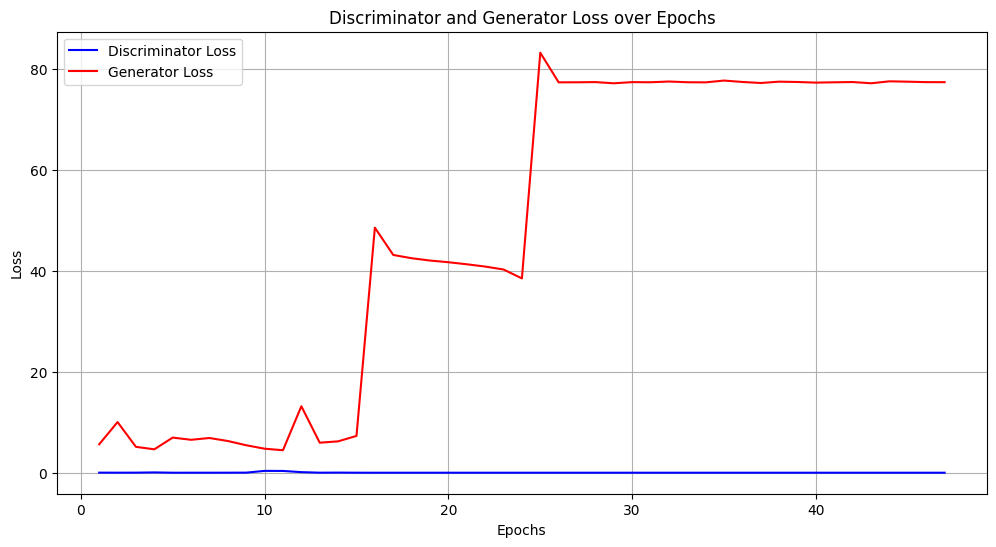

In [ ]:
epochs = list(range(1, 48))
discriminator_loss = [0.0157, 0.0064, 0.0137, 0.0599, 0.0015, 0.0036, 0.0024, 0.0061, 0.0167, 0.3640, 0.3528, 0.1146, 0.0059, 0.0240, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]
generator_loss = [5.6288, 10.0387, 5.1289, 4.6367, 6.9612, 6.5272, 6.8805, 6.2856, 5.4462, 4.7582, 4.4580, 13.1735, 5.9514, 6.2172, 7.2958, 48.5661, 43.1623, 42.5106, 42.0529, 41.7183, 41.3130, 40.8594, 40.2785, 38.5106, 83.2413, 77.3680, 77.3853, 77.4192, 77.1830, 77.4136, 77.3862, 77.5333, 77.3916, 77.3664, 77.7244, 77.4426, 77.2429, 77.5065, 77.4381, 77.3164, 77.3821, 77.4293, 77.1876, 77.5723, 77.5006, 77.4120, 77.4026]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, discriminator_loss, label='Discriminator Loss', color='b')
plt.plot(epochs, generator_loss, label='Generator Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

The output led to mode collapse

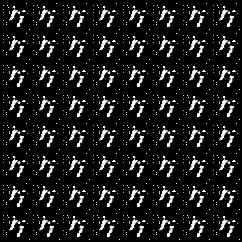

## MNIST testing with changes

Changes:
- feature matching
- label smoothing
- spectral normalization
- mini batch discrimination
- increase in depth

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets and loaders
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)


In [ ]:
def quantum_circuit(params, data, n_qubits=4):
    depth = len(params) // (2 * n_qubits)
    for d in range(depth):
        for i in range(n_qubits):
            qml.RY(data[i], wires=i)
            qml.RY(params[d * 2 * n_qubits + i], wires=i)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
        for i in range(n_qubits):
            qml.RZ(params[d * 2 * n_qubits + n_qubits + i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [ ]:
qnode = qml.QNode(quantum_circuit, dev)

# Parameterized gates
def parameterized_gates(params, wires):
    qml.RX(params[0], wires=wires)
    qml.RY(params[1], wires=wires)
    qml.RZ(params[2], wires=wires)


In [ ]:
class QuantumGenerator(nn.Module):
    def __init__(self, n_qubits=4, depth=3, output_dim=16):
        super(QuantumGenerator, self).__init__()
        self.n_qubits = n_qubits
        self.depth = depth
        self.output_dim = output_dim
        self.params = nn.Parameter(torch.randn((depth * 2 * n_qubits,), requires_grad=True))
        self.fc1 = nn.Linear(output_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 784)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(256)

    def forward(self, x):
        q_out = []
        for i in range(x.shape[0]):
            data = x[i].detach().cpu().numpy()
            result = np.array(qnode(self.params.detach().cpu().numpy(), data))
            q_out.append(result)
        q_out = torch.tensor(q_out, dtype=torch.float32).to(device)
        q_out = F.relu(self.bn1(self.fc1(q_out)))
        q_out = F.relu(self.bn2(self.fc2(q_out)))
        q_out = torch.tanh(self.fc3(q_out))
        return q_out.view(-1, 1, 28, 28)

In [ ]:
gen = QuantumGenerator(n_qubits=n_qubits, depth=3, output_dim=n_qubits).to(device)

In [ ]:
latent_vectors = torch.randn((64, n_qubits)).to(device)
gen_output = gen(latent_vectors)
print("Generator output shape:", gen_output.shape)

C:\Users\adith\AppData\Local\Temp\ipykernel_38236\4250118235.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  q_out = torch.tensor(q_out, dtype=torch.float32).to(device)


Generator output shape: torch.Size([64, 1, 28, 28])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1))
        self.conv3 = spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1))
        self.fc1 = spectral_norm(nn.Linear(256 * 7 * 7, 1))

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x

In [ ]:
discriminator = Discriminator().to(device)
images, _ = next(iter(trainloader))
images = images.to(device)
print("Shape of images before discriminator:", images.shape)
disc_output = discriminator(images)
print("Discriminator output shape:", disc_output.shape)

Shape of images before discriminator: torch.Size([64, 1, 28, 28])
Discriminator output shape: torch.Size([64, 1])


In [ ]:
criterion = nn.BCELoss()

In [ ]:
def create_labels(size, is_real=True):
    return torch.ones(size, 1).to(device) if is_real else torch.zeros(size, 1).to(device)

In [ ]:
lr = 0.0002
beta1 = 0.5
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
n_epochs = 50
batch_size = 64
latent_dim = n_qubits
gen_loss_list = []
disc_loss_list = []

In [ ]:
for epoch in range(n_epochs):
    for i, (images, _) in enumerate(trainloader):
        optimizer_disc.zero_grad()

        real_images = images.to(device)
        real_labels = create_labels(real_images.size(0), is_real=True)
        real_outputs = discriminator(real_images)
        disc_real_loss = criterion(real_outputs, real_labels)

        # Fake
        latent_vectors = torch.randn((batch_size, latent_dim)).to(device)
        fake_images = gen(latent_vectors).view(batch_size, 1, 28, 28)
        fake_labels = create_labels(fake_images.size(0), is_real=False)
        fake_outputs = discriminator(fake_images.detach())
        disc_fake_loss = criterion(fake_outputs, fake_labels)

        disc_loss = disc_real_loss + disc_fake_loss
        disc_loss.backward()
        optimizer_disc.step()

        optimizer_gen.zero_grad()
        fake_outputs = discriminator(fake_images)
        gen_loss = criterion(fake_outputs, create_labels(fake_images.size(0), is_real=True))
        gen_loss.backward()
        optimizer_gen.step()

    gen_loss_list.append(gen_loss.item())
    disc_loss_list.append(disc_loss.item())
    print(f'Epoch [{epoch+1}/{n_epochs}], Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}')

    if (epoch+1) % 2 == 0:
        with torch.no_grad():
            fake_images = gen(latent_vectors).view(batch_size, 1, 28, 28).cpu()
            grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
            torchvision.utils.save_image(grid, f'generated_images_epoch_{epoch+1}.png')


Epoch [1/50], Discriminator Loss: 0.5021, Generator Loss: 1.6239
Epoch [2/50], Discriminator Loss: 0.6690, Generator Loss: 1.1843
Epoch [3/50], Discriminator Loss: 0.8452, Generator Loss: 1.1543
Epoch [4/50], Discriminator Loss: 1.1059, Generator Loss: 1.5380
Epoch [5/50], Discriminator Loss: 1.0100, Generator Loss: 0.9237
Epoch [6/50], Discriminator Loss: 1.0755, Generator Loss: 1.0227
Epoch [7/50], Discriminator Loss: 1.2135, Generator Loss: 1.0382
Epoch [8/50], Discriminator Loss: 1.1273, Generator Loss: 0.6293
Epoch [9/50], Discriminator Loss: 1.1163, Generator Loss: 0.9202
Epoch [10/50], Discriminator Loss: 1.1723, Generator Loss: 0.6769
Epoch [11/50], Discriminator Loss: 1.1719, Generator Loss: 0.9886
Epoch [12/50], Discriminator Loss: 1.1417, Generator Loss: 0.7487
Epoch [13/50], Discriminator Loss: 1.1510, Generator Loss: 0.8279
Epoch [14/50], Discriminator Loss: 1.2357, Generator Loss: 0.4635
Epoch [15/50], Discriminator Loss: 1.1960, Generator Loss: 0.6278
Epoch [16/50], Disc

In [ ]:
def generate_samples(generator, n_samples, latent_dim, save_path=None):
    generator.eval()
    with torch.no_grad():
        latent_vectors = torch.randn((n_samples, latent_dim)).to(device)
        generated_images = generator(latent_vectors).cpu()

        grid = torchvision.utils.make_grid(generated_images, nrow=8, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title('Generated Samples')
        plt.axis('off')

        if save_path:
            torchvision.utils.save_image(grid, save_path)

        plt.show()

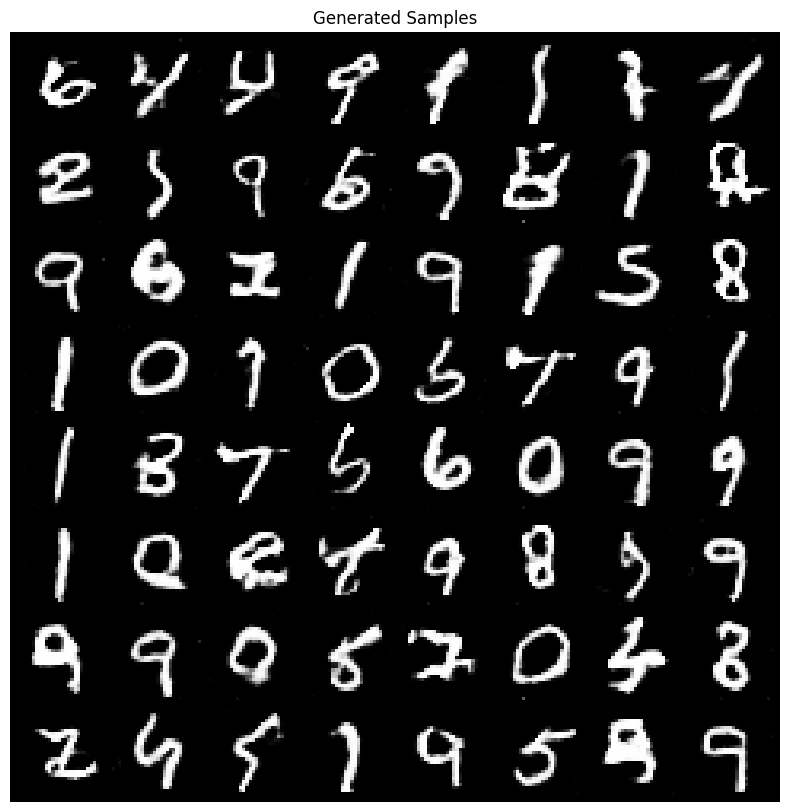

In [ ]:
generate_samples(gen, n_samples=64, latent_dim=n_qubits, save_path='generated_samples_trail4.png')

In [ ]:
def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Loss During Training')
    plt.legend()
    plt.grid(True)
    plt.show()

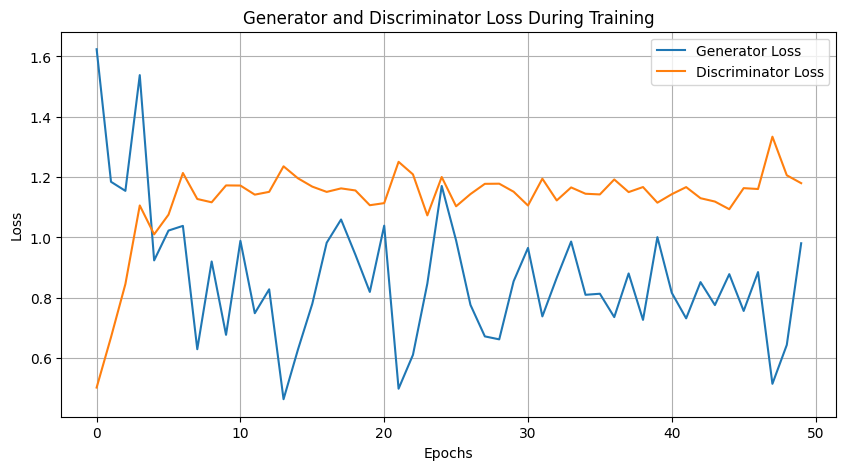

In [ ]:
plot_losses(gen_loss_list, disc_loss_list)

Training-output GIF

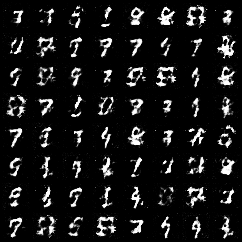

## Jet Mass

### Same pipeline with Jet images

In [ ]:
jet_images_path = 'jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'

In [ ]:
jet_mass_data = HDF5File(jet_images_path, 'r')

In [ ]:
X_jet = jet_mass_data['image']
print(X_jet.shape)

(872666, 25, 25)


In [ ]:
X_jet = np.array(X_jet)
X_jet = torch.tensor(X_jet, dtype=torch.float32)


X_jet = (X_jet - X_jet.min()) / (X_jet.max() - X_jet.min())

X_jet = X_jet.unsqueeze(1)
X_jet_resized = nn.functional.interpolate(X_jet, size=(16, 16), mode='bilinear', align_corners=False)

indices = random.sample(range(X_jet_resized.shape[0]), 100000)
X_jet_sampled = X_jet_resized[indices]

In [ ]:
print(X_jet_sampled.shape)

torch.Size([100000, 1, 16, 16])


In [ ]:
batch_size = 64
jet_dataset = torch.utils.data.TensorDataset(X_jet_sampled)
jet_loader = torch.utils.data.DataLoader(jet_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def quantum_circuit(params, data, n_qubits=4):
    depth = len(params) // (2 * n_qubits)
    for d in range(depth):
        for i in range(n_qubits):
            qml.RY(data[i], wires=i)
            qml.RY(params[d * 2 * n_qubits + i], wires=i)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
        for i in range(n_qubits):
            qml.RZ(params[d * 2 * n_qubits + n_qubits + i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

qnode = qml.QNode(quantum_circuit, dev)


In [ ]:
class QuantumGenerator(nn.Module):
    def __init__(self, n_qubits=4, depth=3, output_dim=16*16):
        super(QuantumGenerator, self).__init__()
        self.n_qubits = n_qubits
        self.depth = depth
        self.output_dim = output_dim
        self.params = nn.Parameter(torch.randn((depth * 2 * n_qubits,), requires_grad=True))
        self.fc1 = nn.Linear(n_qubits, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, self.output_dim)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(256)

    def forward(self, x):
        q_out = []
        for i in range(x.shape[0]):
            data = x[i].detach().cpu().numpy()
            result = np.array(qnode(self.params.detach().cpu().numpy(), data))
            q_out.append(result)
        q_out = torch.tensor(q_out, dtype=torch.float32).to(device)
        q_out = F.relu(self.bn1(self.fc1(q_out)))
        q_out = F.relu(self.bn2(self.fc2(q_out)))
        q_out = torch.tanh(self.fc3(q_out))
        return q_out.view(-1, 1, 16, 16)

In [ ]:
gen = QuantumGenerator(n_qubits=n_qubits, depth=3, output_dim=16*16).to(device)

In [ ]:
latent_vectors = torch.randn((64, n_qubits)).to(device)
gen_output = gen(latent_vectors)
print("Generator output shape:", gen_output.shape)

Generator output shape: torch.Size([64, 1, 16, 16])


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1))
        self.conv3 = spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1))
        self.fc1 = spectral_norm(nn.Linear(256 * 4 * 4, 1))

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x

In [ ]:
discriminator = Discriminator().to(device)
sample_data = next(iter(jet_loader))[0]
sample_data = sample_data.to(device)
print("Shape of sample data before discriminator:", sample_data.shape)
disc_output = discriminator(sample_data)
print("Discriminator output shape:", disc_output.shape)

Shape of sample data before discriminator: torch.Size([64, 1, 16, 16])
Discriminator output shape: torch.Size([64, 1])


In [ ]:
criterion = nn.BCELoss()

In [ ]:
def create_labels(size, is_real=True):
    return torch.ones(size, 1).to(device) if is_real else torch.zeros(size, 1).to(device)

In [ ]:
lr = 0.0002
beta1 = 0.5
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
n_epochs = 50
gen_loss_list = []
disc_loss_list = []

for epoch in range(n_epochs):
    for i, (images,) in enumerate(jet_loader):
        optimizer_disc.zero_grad()

        # Real
        real_images = images.to(device)
        real_labels = create_labels(real_images.size(0), is_real=True)
        real_outputs = discriminator(real_images)
        disc_real_loss = criterion(real_outputs, real_labels)

        # Fake
        latent_vectors = torch.randn((batch_size, latent_dim)).to(device)
        fake_images = gen(latent_vectors).view(batch_size, 1, 16, 16)
        fake_labels = create_labels(fake_images.size(0), is_real=False)
        fake_outputs = discriminator(fake_images.detach())
        disc_fake_loss = criterion(fake_outputs, fake_labels)

        disc_loss = disc_real_loss + disc_fake_loss
        disc_loss.backward()
        optimizer_disc.step()

        optimizer_gen.zero_grad()
        fake_outputs = discriminator(fake_images)
        gen_loss = criterion(fake_outputs, create_labels(fake_images.size(0), is_real=True))
        gen_loss.backward()
        optimizer_gen.step()

    gen_loss_list.append(gen_loss.item())
    disc_loss_list.append(disc_loss.item())
    print(f'Epoch [{epoch+1}/{n_epochs}], Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}')

    if (epoch+1) % 2 == 0:
        with torch.no_grad():
            fake_images = gen(latent_vectors).view(batch_size, 1, 16, 16).cpu()
            grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
            torchvision.utils.save_image(grid, f'generated_Jet_images_epoch_{epoch+1}.png')

Epoch [1/50], Discriminator Loss: 1.3178, Generator Loss: 0.7581
Epoch [2/50], Discriminator Loss: 1.3237, Generator Loss: 0.7280
Epoch [3/50], Discriminator Loss: 1.3298, Generator Loss: 0.7128
Epoch [4/50], Discriminator Loss: 1.3368, Generator Loss: 0.7229
Epoch [5/50], Discriminator Loss: 1.3376, Generator Loss: 0.7283
Epoch [6/50], Discriminator Loss: 1.3319, Generator Loss: 0.7157
Epoch [7/50], Discriminator Loss: 1.3377, Generator Loss: 0.7169
Epoch [8/50], Discriminator Loss: 1.3483, Generator Loss: 0.7194
Epoch [9/50], Discriminator Loss: 1.3356, Generator Loss: 0.7028
Epoch [10/50], Discriminator Loss: 1.3515, Generator Loss: 0.6941
Epoch [11/50], Discriminator Loss: 1.3568, Generator Loss: 0.7028
Epoch [12/50], Discriminator Loss: 1.3580, Generator Loss: 0.6932
Epoch [13/50], Discriminator Loss: 1.3566, Generator Loss: 0.6946
Epoch [14/50], Discriminator Loss: 1.3723, Generator Loss: 0.7028
Epoch [15/50], Discriminator Loss: 1.3560, Generator Loss: 0.6938
Epoch [16/50], Disc

In [ ]:
def generate_samples(generator, n_samples, latent_dim, save_path=None):
    generator.eval()
    with torch.no_grad():
        latent_vectors = torch.randn((n_samples, latent_dim)).to(device)
        generated_images = generator(latent_vectors).cpu()

        grid = torchvision.utils.make_grid(generated_images, nrow=8, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.title('Generated Samples')
        plt.axis('off')

        if save_path:
            torchvision.utils.save_image(grid, save_path)

        plt.show()

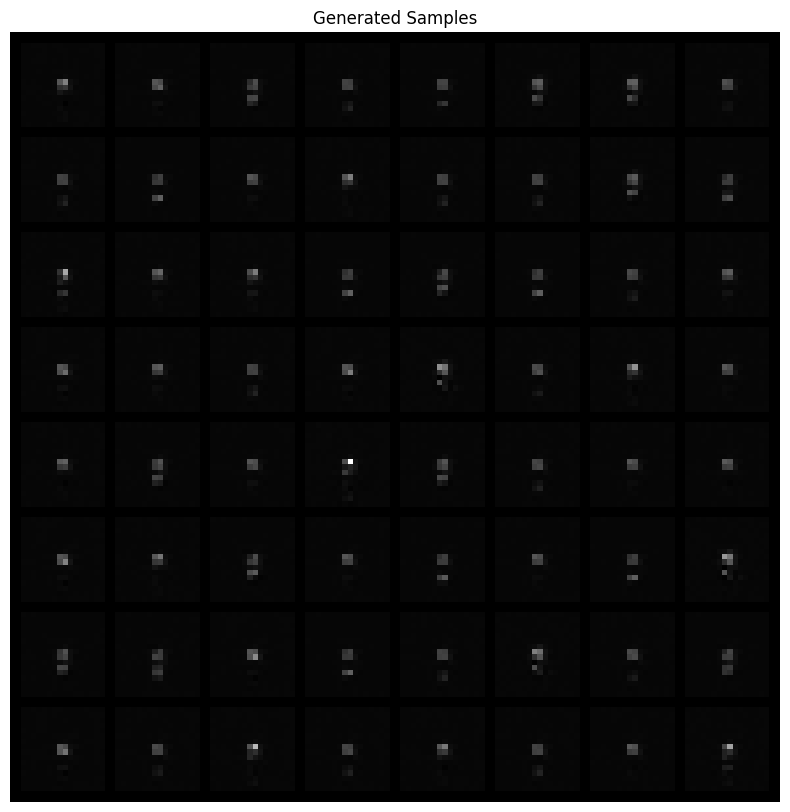

In [ ]:
generate_samples(gen, n_samples=64, latent_dim=n_qubits, save_path='generated_samples_jet_image.png')

In [ ]:
def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Loss During Training')
    plt.legend()
    plt.grid(True)
    plt.show()

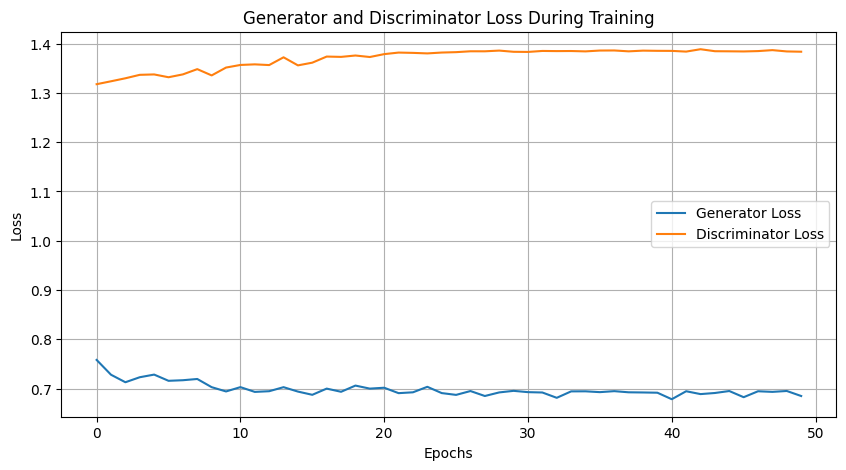

In [ ]:
plot_losses(gen_loss_list, disc_loss_list)

### BCE loss with FID eval
We will now use FID scores to evaluate the networks

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

jet_images_path = 'jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
with h5py.File(jet_images_path, 'r') as f:
    X_jet = np.array(f['image'])

X_jet = torch.tensor(X_jet, dtype=torch.float32)
X_jet = (X_jet - X_jet.min()) / (X_jet.max() - X_jet.min())
X_jet = X_jet.unsqueeze(1)
X_jet_resized = nn.functional.interpolate(X_jet, size=(16, 16), mode='bilinear', align_corners=False)

indices = random.sample(range(X_jet_resized.shape[0]), 100000)
X_jet_sampled = X_jet_resized[indices]
batch_size = 64
jet_dataset = TensorDataset(X_jet_sampled)
jet_loader = DataLoader(jet_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
n_qubits = 4
latent_dim = n_qubits
dev = qml.device('default.qubit', wires=n_qubits)

def quantum_circuit(params, data, n_qubits=4):
    depth = len(params) // (2 * n_qubits)
    for d in range(depth):
        for i in range(n_qubits):
            qml.RY(data[i], wires=i)
            qml.RY(params[d * 2 * n_qubits + i], wires=i)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
        for i in range(n_qubits):
            qml.RZ(params[d * 2 * n_qubits + n_qubits + i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

qnode = qml.QNode(quantum_circuit, dev)

class QuantumGenerator(nn.Module):
    def __init__(self, n_qubits=4, depth=3, output_dim=16*16):
        super(QuantumGenerator, self).__init__()
        self.n_qubits = n_qubits
        self.depth = depth
        self.output_dim = output_dim
        self.params = nn.Parameter(torch.randn((depth * 2 * n_qubits,), requires_grad=True))
        self.fc1 = nn.Linear(n_qubits, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, self.output_dim)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(256)

    def forward(self, x):
        q_out = []
        for i in range(x.shape[0]):
            data = x[i].detach().cpu().numpy()
            result = np.array(qnode(self.params.detach().cpu().numpy(), data))
            q_out.append(result)
        q_out = torch.tensor(q_out, dtype=torch.float32).to(device)
        q_out = F.relu(self.bn1(self.fc1(q_out)))
        q_out = F.relu(self.bn2(self.fc2(q_out)))
        q_out = torch.tanh(self.fc3(q_out))
        return q_out.view(-1, 1, 16, 16)

gen = QuantumGenerator(n_qubits=n_qubits, depth=3, output_dim=16*16).to(device)
latent_vectors = torch.randn((64, n_qubits)).to(device)
gen_output = gen(latent_vectors)
print("Generator output shape:", gen_output.shape)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1))
        self.conv3 = spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1))
        self.fc1 = spectral_norm(nn.Linear(256 * 4 * 4, 1))

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x

discriminator = Discriminator().to(device)
sample_data = next(iter(jet_loader))[0]
sample_data = sample_data.to(device)
print("Shape of sample data before discriminator:", sample_data.shape)
disc_output = discriminator(sample_data)
print("Discriminator output shape:", disc_output.shape)

criterion = nn.BCELoss()

def create_labels(size, is_real=True):
    return torch.ones(size, 1).to(device) if is_real else torch.zeros(size, 1).to(device)

lr = 0.0002
beta1 = 0.5
optimizer_gen = Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_disc = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


def calculate_fid(real_images, fake_images):
    from scipy.linalg import sqrtm
    real_images = real_images.cpu().detach().numpy().reshape(real_images.shape[0], -1)
    fake_images = fake_images.cpu().detach().numpy().reshape(fake_images.shape[0], -1)

    mu_real, sigma_real = np.mean(real_images, axis=0), np.cov(real_images, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_images, axis=0), np.cov(fake_images, rowvar=False)

    ssdiff = np.sum((mu_real - mu_fake) ** 2.0)
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    return fid

n_epochs = 30
gen_loss_list = []
disc_loss_list = []
fid_list = []

C:\Users\adith\AppData\Local\Temp\ipykernel_22804\3812542167.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  q_out = torch.tensor(q_out, dtype=torch.float32).to(device)


Generator output shape: torch.Size([64, 1, 16, 16])
Shape of sample data before discriminator: torch.Size([64, 1, 16, 16])
Discriminator output shape: torch.Size([64, 1])


In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [ ]:
def plot_generated_samples(generator, latent_dim, num_samples=16):
    z = torch.randn(num_samples, latent_dim).to(device)
    gen_samples = generator(z).detach().cpu()
    gen_samples = (gen_samples + 1) / 2.0

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        img = gen_samples[i, 0].numpy()
        # img_smoothed = gaussian_filter(img, sigma=1)
        axes[i].imshow(img_smoothed, cmap='viridis')
        axes[i].axis('off')
    plt.show()


Epoch [1/30], Discriminator Loss: 1.3660, Generator Loss: 0.7046
Epoch [1/30], FID: 0.0069


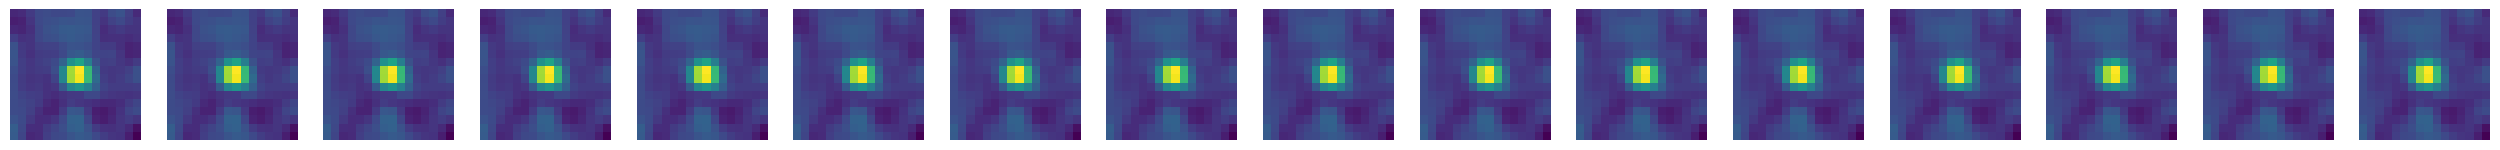

Epoch [2/30], Discriminator Loss: 1.3267, Generator Loss: 0.7500
Epoch [2/30], FID: 0.0084


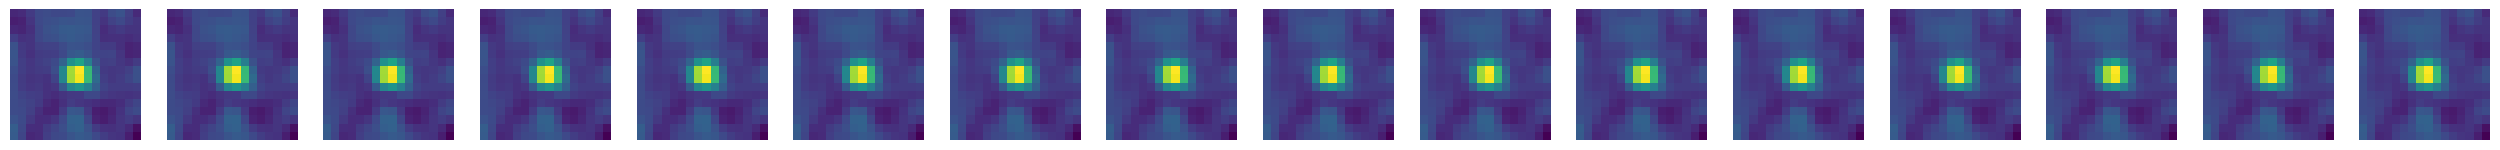

KeyboardInterrupt: 

In [ ]:
for epoch in range(n_epochs):
    for i, (images,) in enumerate(jet_loader):
        optimizer_disc.zero_grad()

        real_images = images.to(device)
        real_labels = create_labels(real_images.size(0), is_real=True)
        real_outputs = discriminator(real_images)
        disc_real_loss = criterion(real_outputs, real_labels)

        latent_vectors = torch.randn((batch_size, latent_dim)).to(device)
        fake_images = gen(latent_vectors).view(batch_size, 1, 16, 16)
        fake_labels = create_labels(fake_images.size(0), is_real=False)
        fake_outputs = discriminator(fake_images.detach())
        disc_fake_loss = criterion(fake_outputs, fake_labels)

        disc_loss = disc_real_loss + disc_fake_loss
        disc_loss.backward()
        optimizer_disc.step()

        optimizer_gen.zero_grad()
        fake_outputs = discriminator(fake_images)
        gen_loss = criterion(fake_outputs, create_labels(fake_images.size(0), is_real=True))
        gen_loss.backward()
        optimizer_gen.step()

    gen_loss_list.append(gen_loss.item())
    disc_loss_list.append(disc_loss.item())
    print(f'Epoch [{epoch+1}/{n_epochs}], Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}')

    with torch.no_grad():
        fake_images = gen(latent_vectors).view(batch_size, 1, 16, 16).cpu()
        real_images = next(iter(jet_loader))[0].cpu()
        fid = calculate_fid(real_images, fake_images)
        fid_list.append(fid)
        print(f'Epoch [{epoch+1}/{n_epochs}], FID: {fid:.4f}')

    plot_generated_samples(gen, latent_dim)

Stoped execution due to **Mode collapse**

### Total variation with FID eval
Since the output mode collapses we will try changing the loss function from binary cross entropy to total variation

In [ ]:
n_qubits = 4
latent_dim = n_qubits
dev = qml.device('default.qubit', wires=n_qubits)

def quantum_circuit(params, data, n_qubits=4):
    depth = len(params) // (2 * n_qubits)
    for d in range(depth):
        for i in range(n_qubits):
            qml.RY(data[i], wires=i)
            qml.RY(params[d * 2 * n_qubits + i], wires=i)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
        for i in range(n_qubits):
            qml.RZ(params[d * 2 * n_qubits + n_qubits + i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

qnode = qml.QNode(quantum_circuit, dev)

class QuantumGenerator(nn.Module):
    def __init__(self, n_qubits=4, depth=3, output_dim=16*16):
        super(QuantumGenerator, self).__init__()
        self.n_qubits = n_qubits
        self.depth = depth
        self.output_dim = output_dim
        self.params = nn.Parameter(torch.randn((depth * 2 * n_qubits,), requires_grad=True))
        self.fc1 = nn.Linear(n_qubits, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, self.output_dim)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(256)

    def forward(self, x):
        q_out = []
        for i in range(x.shape[0]):
            data = x[i].detach().cpu().numpy()
            result = np.array(qnode(self.params.detach().cpu().numpy(), data))
            q_out.append(result)
        q_out = torch.tensor(q_out, dtype=torch.float32).to(device)
        q_out = F.relu(self.bn1(self.fc1(q_out)))
        q_out = F.relu(self.bn2(self.fc2(q_out)))
        q_out = torch.tanh(self.fc3(q_out))
        return q_out.view(-1, 1, 16, 16)

gen = QuantumGenerator(n_qubits=n_qubits, depth=3, output_dim=16*16).to(device)
latent_vectors = torch.randn((64, n_qubits)).to(device)
gen_output = gen(latent_vectors)
print("Generator output shape:", gen_output.shape)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1))
        self.conv2 = spectral_norm(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1))
        self.conv3 = spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1))
        self.fc1 = spectral_norm(nn.Linear(256 * 4 * 4, 1))

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x

discriminator = Discriminator().to(device)
sample_data = next(iter(jet_loader))[0]
sample_data = sample_data.to(device)
print("Shape of sample data before discriminator:", sample_data.shape)
disc_output = discriminator(sample_data)
print("Discriminator output shape:", disc_output.shape)


def total_variation_loss(img, weight=1e-5):
    batch_size, _, height, width = img.size()
    tv_h = torch.mean(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))
    tv_w = torch.mean(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))
    return weight * (tv_h + tv_w)

lr = 0.0002
beta1 = 0.5
optimizer_gen = Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_disc = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


def calculate_fid(real_images, fake_images):
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    real_images = F.interpolate(real_images, size=(299, 299), mode='bilinear')
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear')

    real_images = real_images.repeat(1, 3, 1, 1)
    fake_images = fake_images.repeat(1, 3, 1, 1)

    def get_activations(images):
        activations = []
        with torch.no_grad():
            for img in images:
                act = inception_model(img.unsqueeze(0)).view(-1)
                activations.append(act.cpu().numpy())
        return np.array(activations)

    real_activations = get_activations(real_images)
    fake_activations = get_activations(fake_images)

    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)

    fid_score = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(np.dot(sigma_real, sigma_fake)))
    return fid_score

def plot_generated_samples(generator, latent_dim, num_samples=16):
    z = torch.randn(num_samples, latent_dim).to(device)
    gen_samples = generator(z).detach().cpu()
    gen_samples = (gen_samples + 1) / 2.0

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        img = gen_samples[i, 0].numpy()
        # img_smoothed = gaussian_filter(img, sigma=1)
        axes[i].imshow(img_smoothed, cmap='viridis')
        axes[i].axis('off')
    plt.show()


n_epochs = 30
gen_loss_list = []
disc_loss_list = []
fid_scores = []

Generator output shape: torch.Size([64, 1, 16, 16])
Shape of sample data before discriminator: torch.Size([64, 1, 16, 16])
Discriminator output shape: torch.Size([64, 1])


Epoch [1/30], Discriminator Loss: 1.3503, Generator Loss: 0.7194


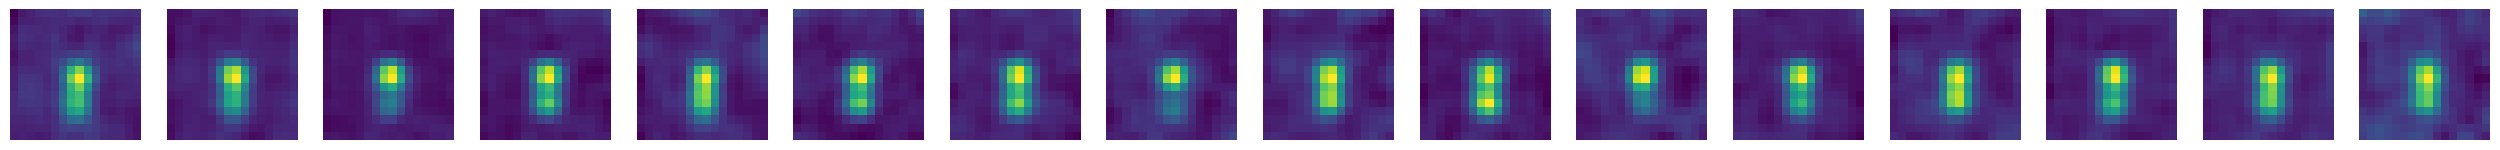

Epoch [1/30], FID Score: 57.7426-0.0000j
Epoch [2/30], Discriminator Loss: 1.3402, Generator Loss: 0.7120


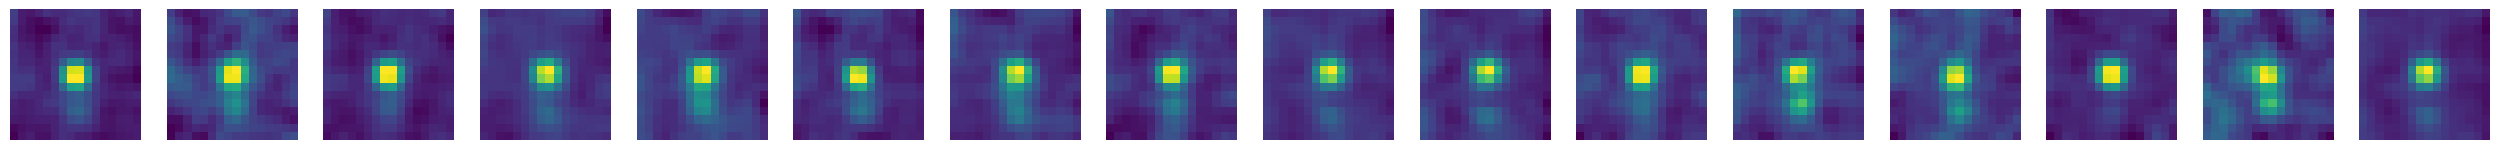

Epoch [2/30], FID Score: 84.0431-0.0000j
Epoch [3/30], Discriminator Loss: 1.3525, Generator Loss: 0.7316


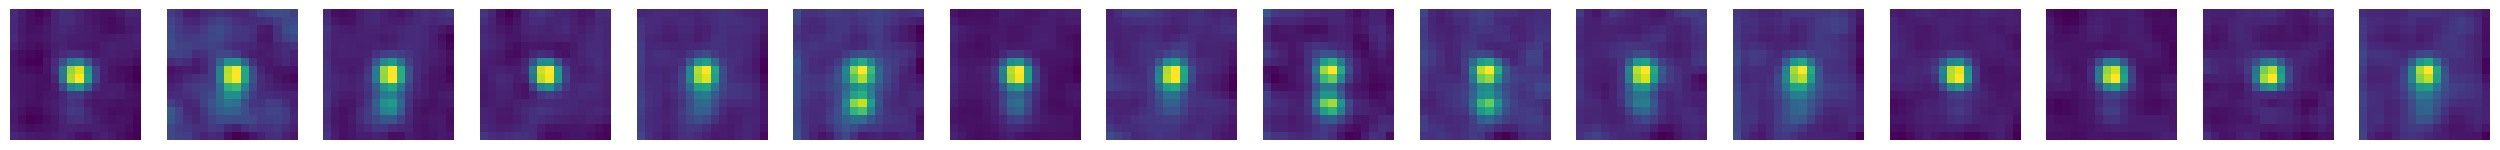

Epoch [3/30], FID Score: 46.1166-0.0000j
Epoch [4/30], Discriminator Loss: 1.3461, Generator Loss: 0.7063


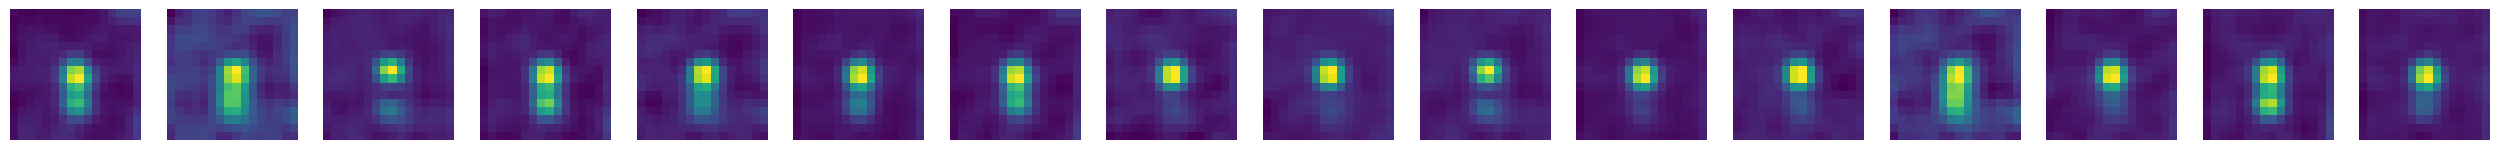

Epoch [4/30], FID Score: 39.5849-0.0000j
Epoch [5/30], Discriminator Loss: 1.3473, Generator Loss: 0.7336


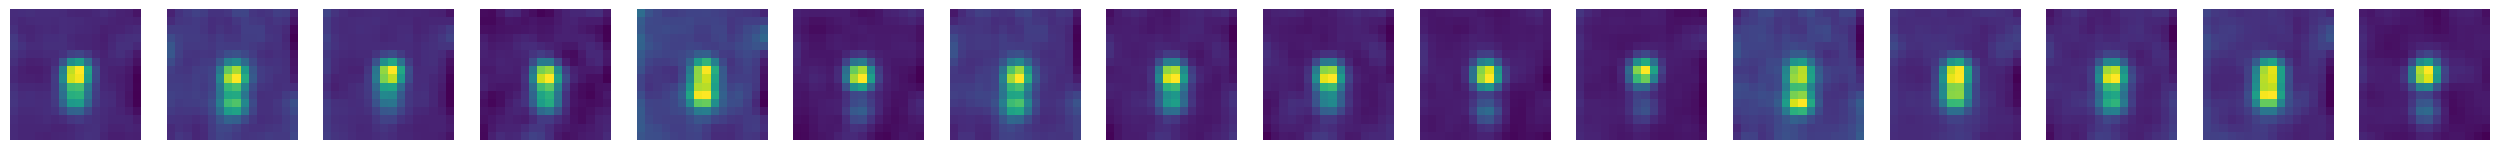

Epoch [5/30], FID Score: 26.8255-0.0000j
Epoch [6/30], Discriminator Loss: 1.3743, Generator Loss: 0.7108


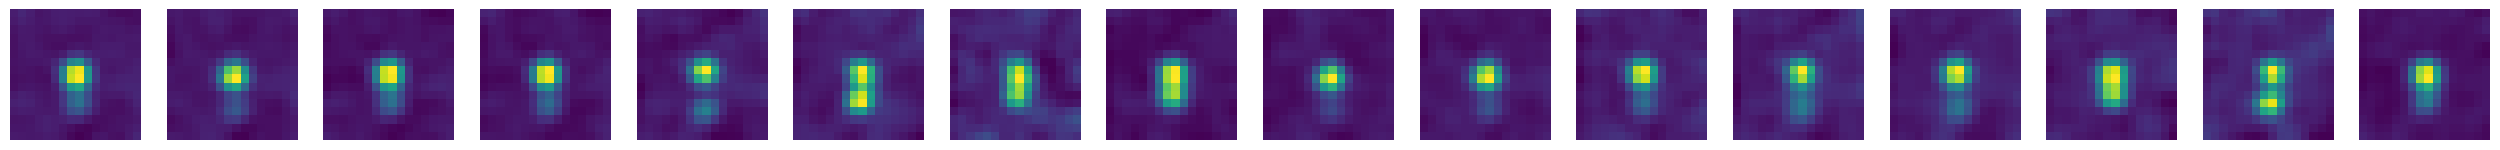

Epoch [6/30], FID Score: 41.4035-0.0000j
Epoch [7/30], Discriminator Loss: 1.3495, Generator Loss: 0.7260


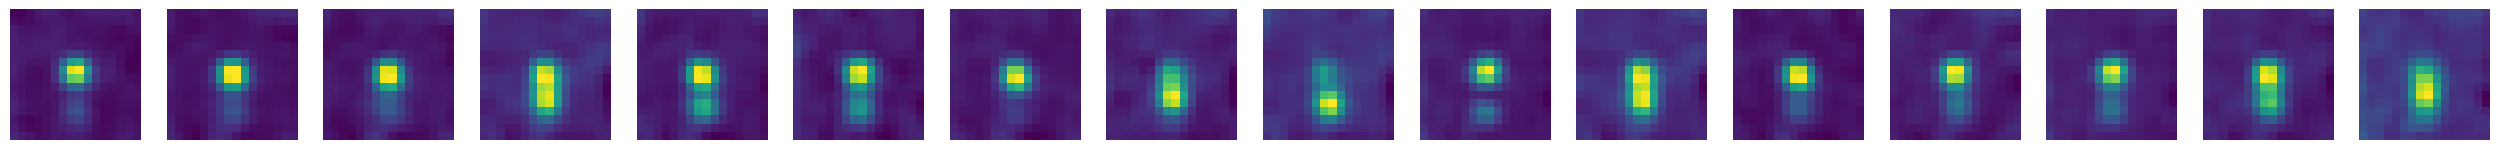

Epoch [7/30], FID Score: 83.5951-0.0000j
Epoch [8/30], Discriminator Loss: 1.3534, Generator Loss: 0.7060


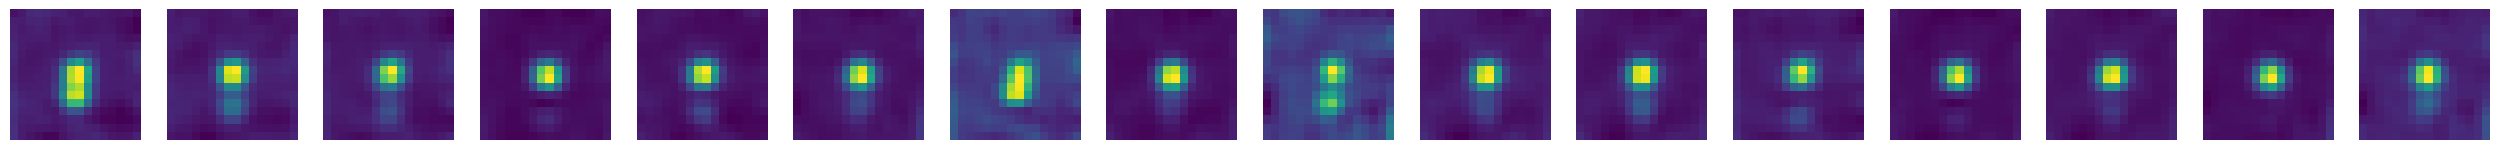

Epoch [8/30], FID Score: 32.2349-0.0000j
Epoch [9/30], Discriminator Loss: 1.3563, Generator Loss: 0.7028


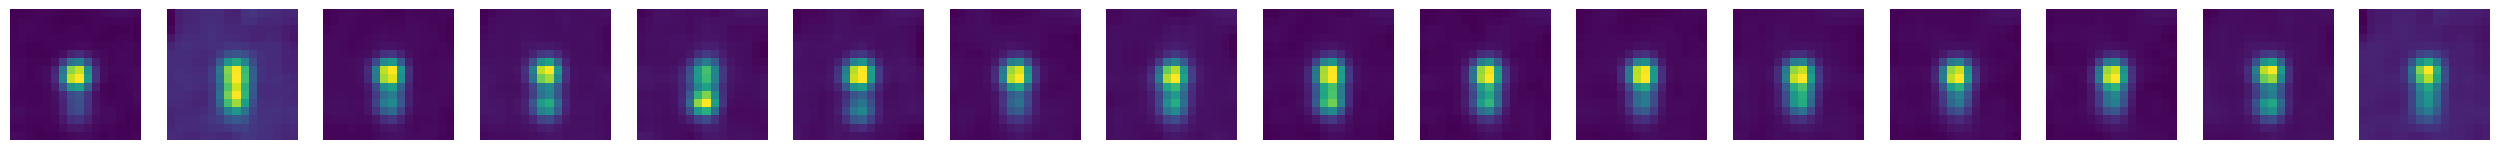

Epoch [9/30], FID Score: 47.6506-0.0000j
Epoch [10/30], Discriminator Loss: 1.3690, Generator Loss: 0.7050


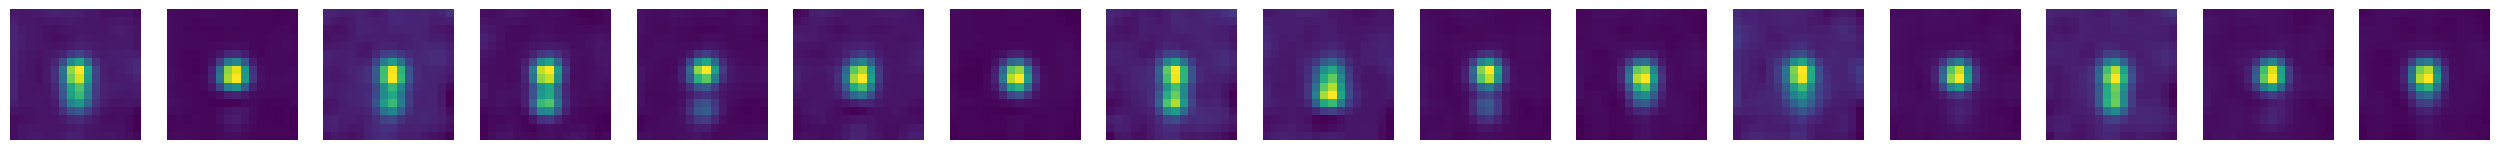

Epoch [10/30], FID Score: 17.3290-0.0000j
Epoch [11/30], Discriminator Loss: 1.3592, Generator Loss: 0.7035


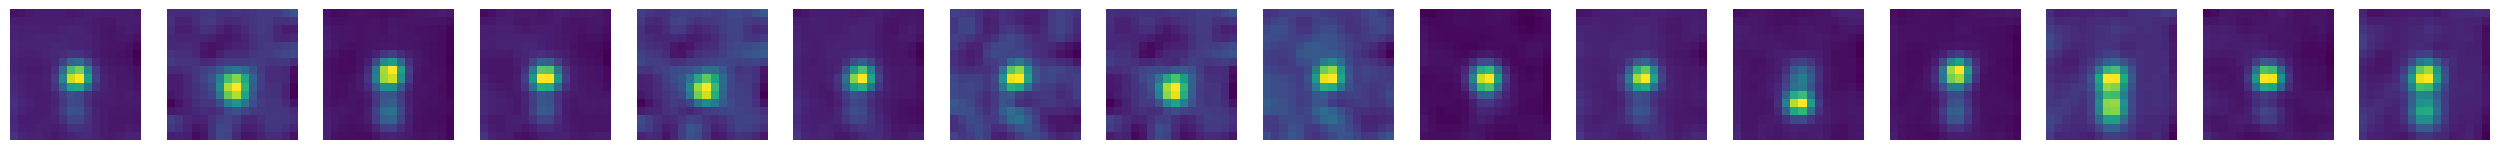

Epoch [11/30], FID Score: 19.5051-0.0000j
Epoch [12/30], Discriminator Loss: 1.3709, Generator Loss: 0.6934


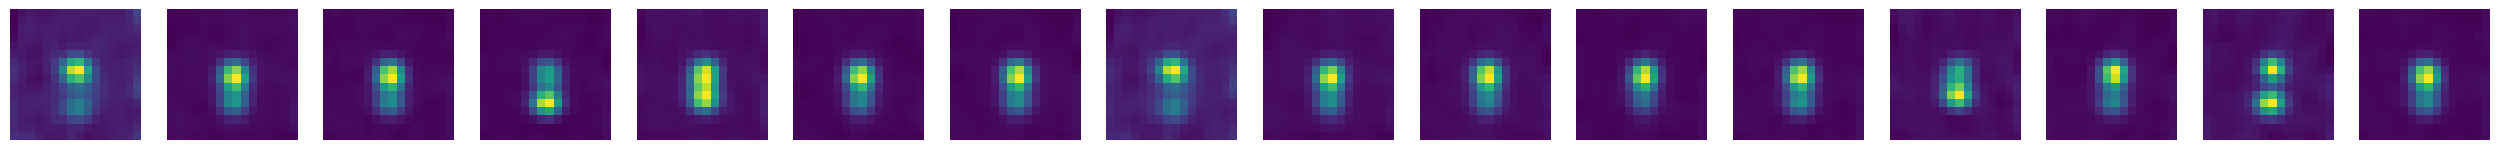

Epoch [12/30], FID Score: 20.1177-0.0000j
Epoch [13/30], Discriminator Loss: 1.3768, Generator Loss: 0.7002


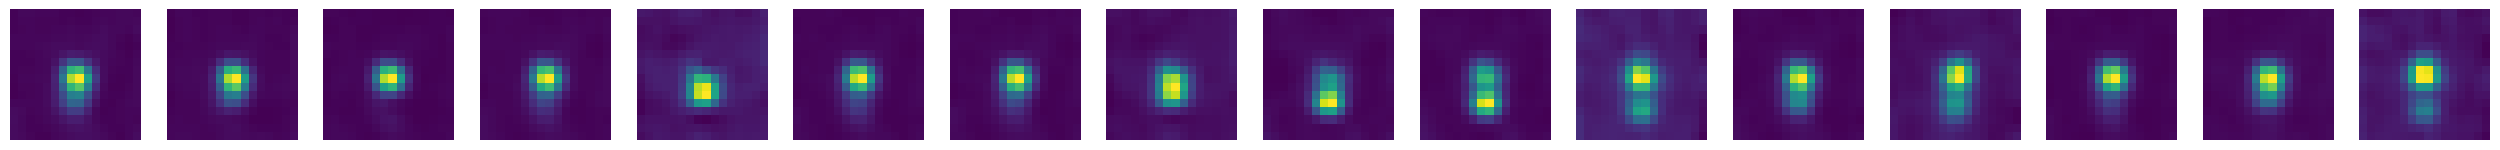

Epoch [13/30], FID Score: 74.9954-0.0000j
Epoch [14/30], Discriminator Loss: 1.3747, Generator Loss: 0.7044


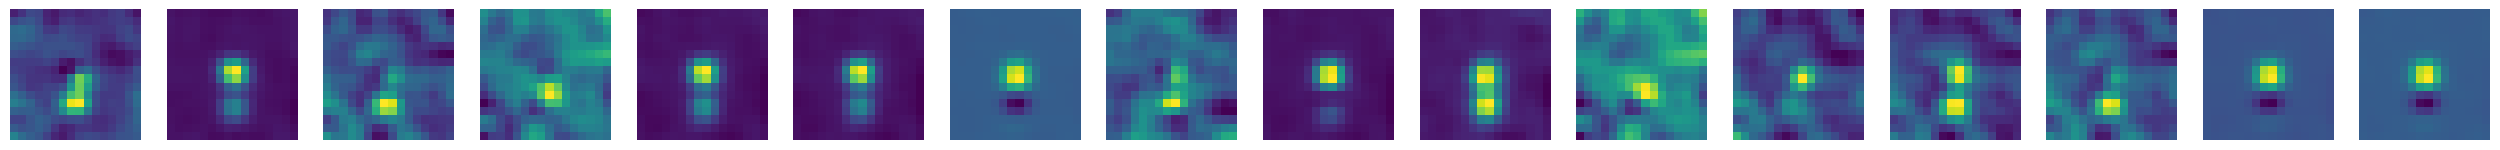

Epoch [14/30], FID Score: 39.6367-0.0000j
Epoch [15/30], Discriminator Loss: 1.3789, Generator Loss: 0.6972


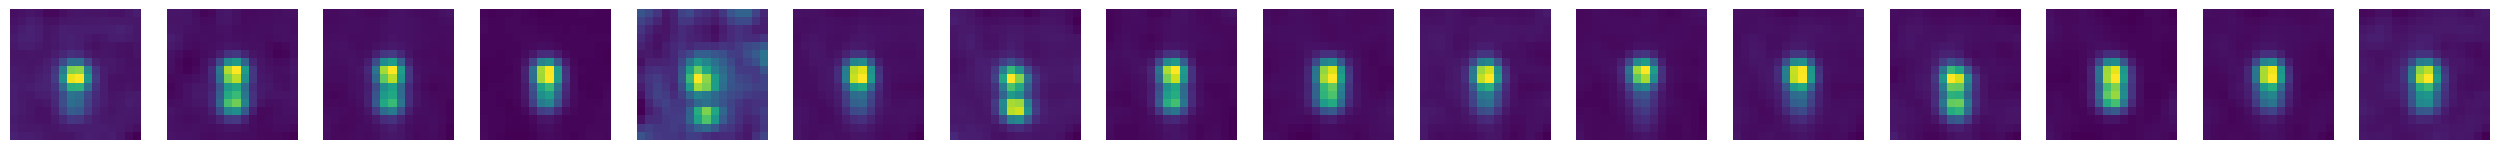

Epoch [15/30], FID Score: 39.3519-0.0000j
Epoch [16/30], Discriminator Loss: 1.3693, Generator Loss: 0.6977


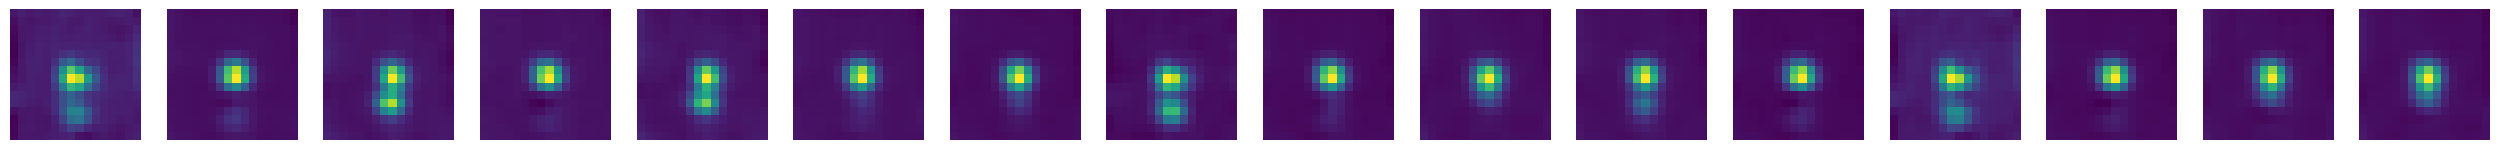

Epoch [16/30], FID Score: 59.3190-0.0000j
Epoch [17/30], Discriminator Loss: 1.3766, Generator Loss: 0.6982


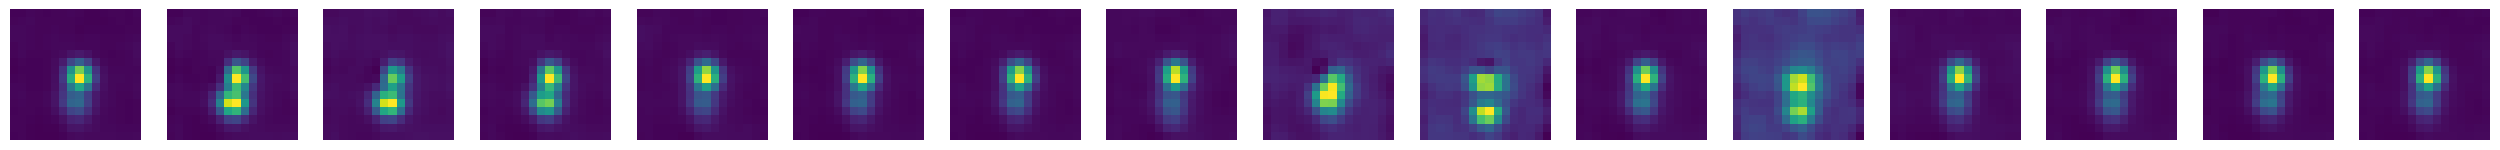

Epoch [17/30], FID Score: 21.8411-0.0000j
Epoch [18/30], Discriminator Loss: 1.3709, Generator Loss: 0.6862


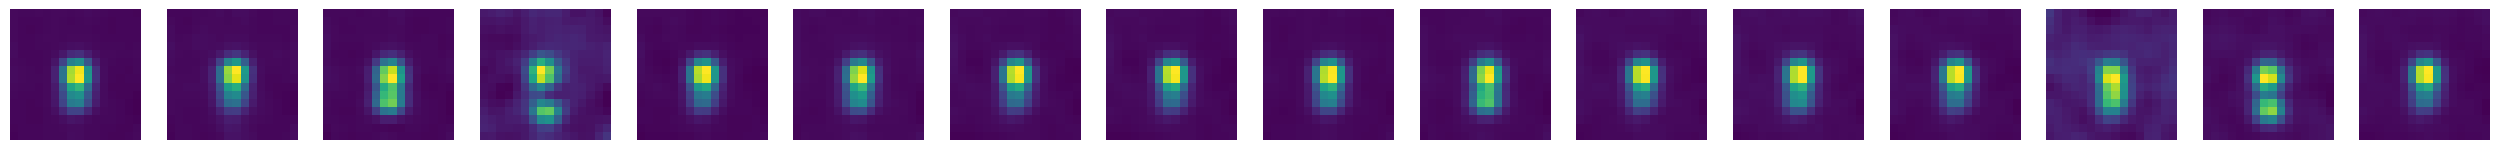

Epoch [18/30], FID Score: 269.4588-0.0000j
Epoch [19/30], Discriminator Loss: 1.3822, Generator Loss: 0.6960


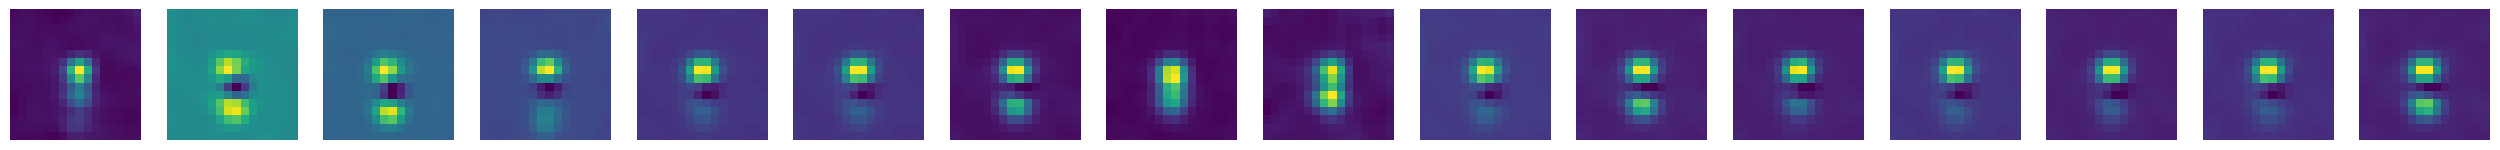

Epoch [19/30], FID Score: 22.1565-0.0000j
Epoch [20/30], Discriminator Loss: 1.3823, Generator Loss: 0.7267


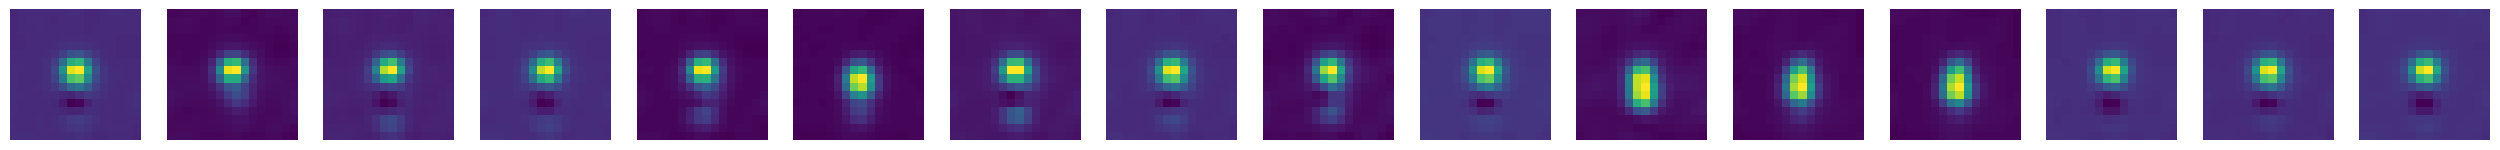

Epoch [20/30], FID Score: 29.2352-0.0000j
Epoch [21/30], Discriminator Loss: 1.3842, Generator Loss: 0.7115


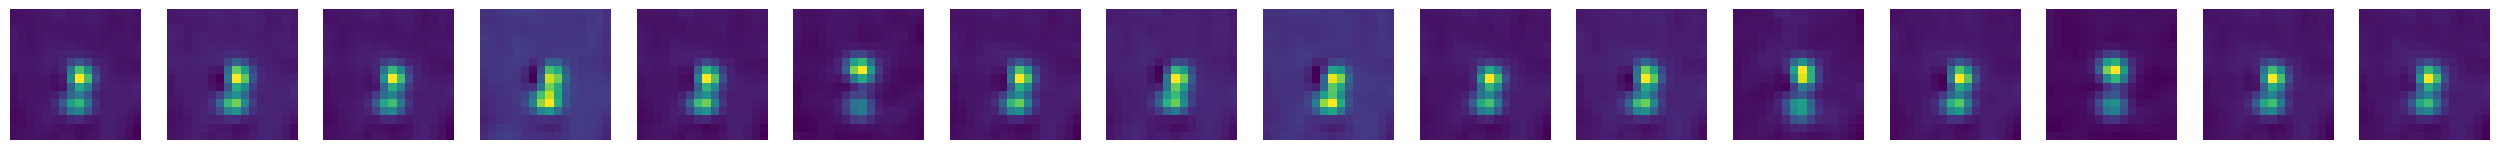

Epoch [21/30], FID Score: 60.6032-0.0000j
Epoch [22/30], Discriminator Loss: 1.3841, Generator Loss: 0.6955


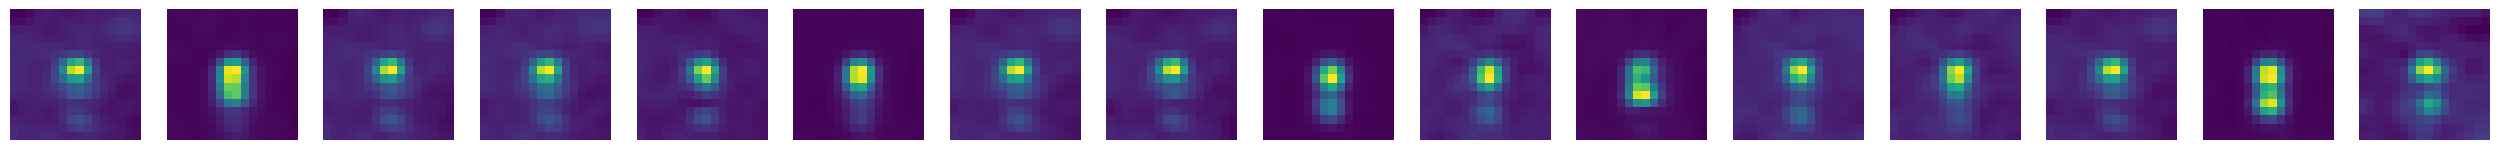

Epoch [22/30], FID Score: 29.3585-0.0000j
Epoch [23/30], Discriminator Loss: 1.3848, Generator Loss: 0.6898


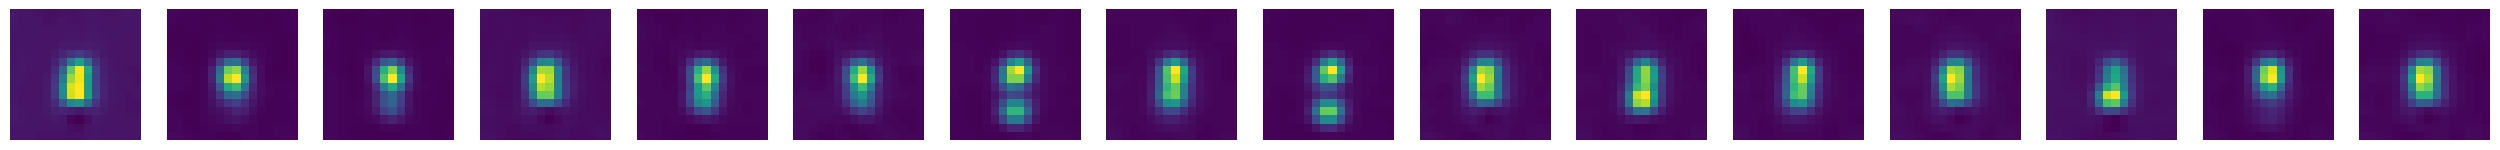

Epoch [23/30], FID Score: 36.0837-0.0000j
Epoch [24/30], Discriminator Loss: 1.3884, Generator Loss: 0.6966


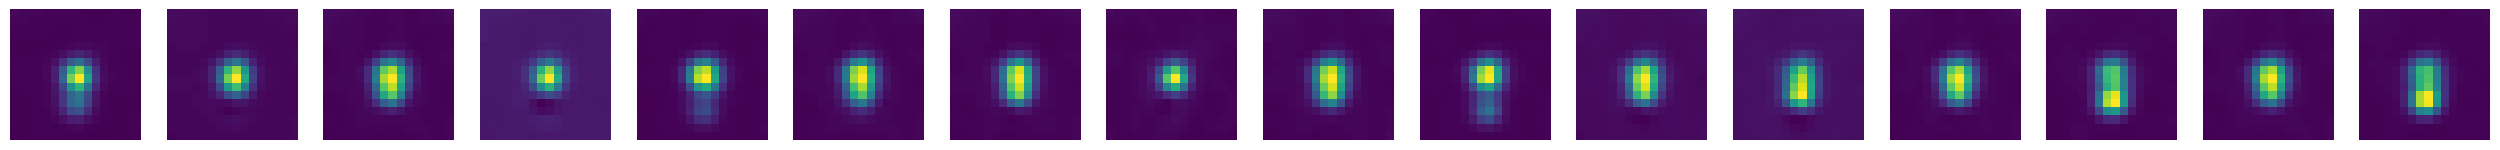

Epoch [24/30], FID Score: 46.7333-0.0000j
Epoch [25/30], Discriminator Loss: 1.3852, Generator Loss: 0.6980


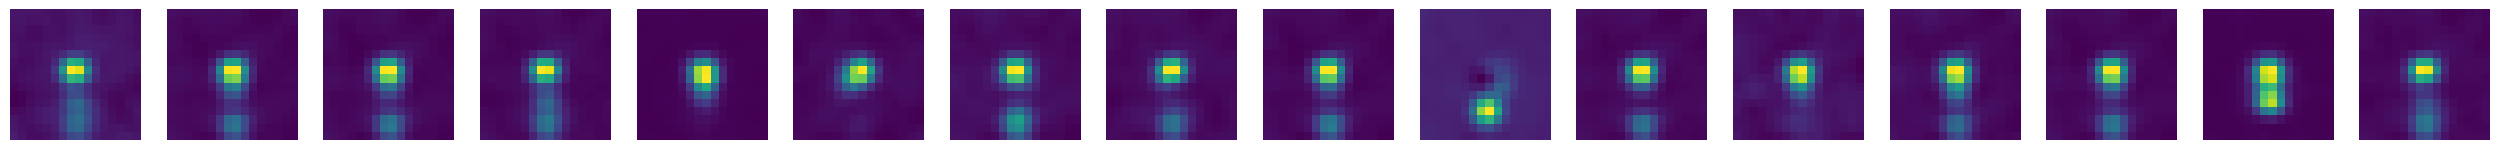

Epoch [25/30], FID Score: 107.1775-0.0000j
Epoch [26/30], Discriminator Loss: 1.3872, Generator Loss: 0.7053


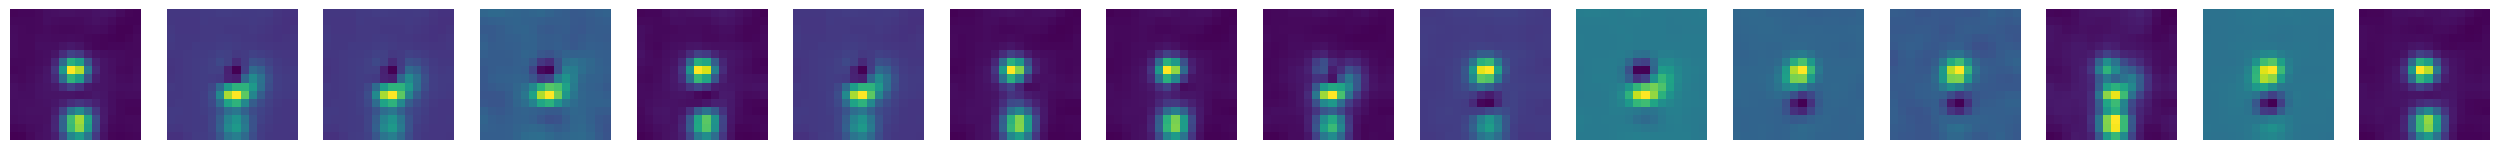

Epoch [26/30], FID Score: 16.5335-0.0000j
Epoch [27/30], Discriminator Loss: 1.3848, Generator Loss: 0.6972


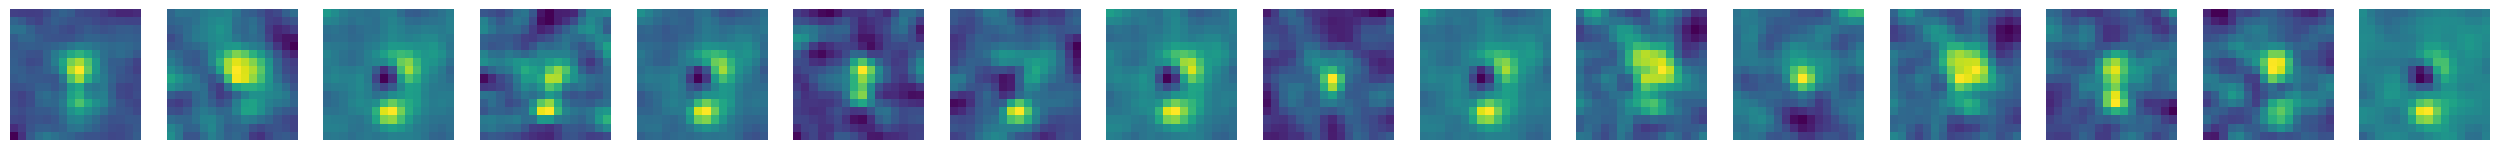

Epoch [27/30], FID Score: 23.9330-0.0000j
Epoch [28/30], Discriminator Loss: 1.3841, Generator Loss: 0.6841


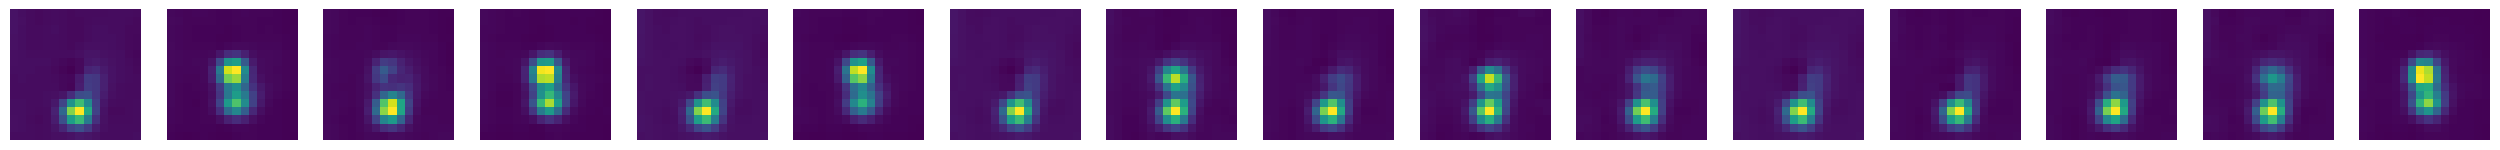

Epoch [28/30], FID Score: 39.4395-0.0000j


In [ ]:
for epoch in range(n_epochs):
    for i, (images,) in enumerate(jet_loader):
        optimizer_disc.zero_grad()


        real_images = images.to(device)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        real_outputs = discriminator(real_images)
        disc_real_loss = total_variation_loss(real_images) + F.binary_cross_entropy(real_outputs, real_labels)


        latent_vectors = torch.randn((batch_size, latent_dim)).to(device)
        fake_images = gen(latent_vectors).view(batch_size, 1, 16, 16)
        fake_labels = torch.zeros(fake_images.size(0), 1).to(device)
        fake_outputs = discriminator(fake_images.detach())
        disc_fake_loss = F.binary_cross_entropy(fake_outputs, fake_labels)

        disc_loss = disc_real_loss + disc_fake_loss
        disc_loss.backward()
        optimizer_disc.step()

        optimizer_gen.zero_grad()
        fake_outputs = discriminator(fake_images)
        gen_labels = torch.ones(fake_images.size(0), 1).to(device)  # Ensure correct size
        gen_loss = total_variation_loss(fake_images) + F.binary_cross_entropy(fake_outputs, gen_labels)
        gen_loss.backward()
        optimizer_gen.step()


    gen_loss_list.append(gen_loss.item())
    disc_loss_list.append(disc_loss.item())
    print(f'Epoch [{epoch+1}/{n_epochs}], Discriminator Loss: {disc_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}')

    if (epoch+1) % 1 == 0:
        plot_generated_samples(gen, latent_dim, num_samples=16)


    with torch.no_grad():
        fid_score = calculate_fid(real_images, fake_images)
        print(f'Epoch [{epoch+1}/{n_epochs}], FID Score: {fid_score:.4f}')
        fid_scores.append(fid_score)
